## Human in the loop interactions

In [2]:
from dotenv import load_dotenv

_ = load_dotenv()

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver

# memory = SqliteSaver.from_conn_string(":memory:")

from contextlib import ExitStack

stack = ExitStack()
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

#our checkpointer for the agent graph memmory (persistence)

In [4]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages] #instead of operator.add

In [5]:
tool = TavilySearchResults(max_results=2)

### Adding interrupt for human approval between node calls

In order to add manual human approval, we'll just add the `interrupt_before=["action"]` parameter inside the graph.compile()

- This means that the agent graph will stop running in any moment it gets to do an **action** (e.g tool call)

- This is when, us, the humans, can decide whether letting the agent keeping the execution, or not

In [6]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [8]:
messages = [HumanMessage(content="Whats the weather in SF?")]

thread = {"configurable": {"thread_id": "1"}} #we'll be running the graph inside this context thread=1

for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33a8a3d2-5077-4db0-8d30-056150f94376'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ERPDqAppWJ378pGYLBpyf2xe', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6b7dd24c-6e5d-45be-b49f-aae5332f856a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ERPDqAppWJ378pGYLBpyf2xe',

We see here how, the `interrupt_before=["action"]` makes the graph stop here.

It prepared a query for the search api, and then attempted to call `tavily` tool 

In [9]:
#within this function, we can access to the particular state of the graph at this specific point 
#we'll get a "copy" of the agent at this particular moment

abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33a8a3d2-5077-4db0-8d30-056150f94376'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ERPDqAppWJ378pGYLBpyf2xe', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6b7dd24c-6e5d-45be-b49f-aae5332f856a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ERPDq

By calling `.next` attribute, we can clearly see how the next node the agent has to execute is `action` (where we instructed to stop at)

In [10]:
abot.graph.get_state(thread).next #renember to pass in the thread we're running on the agent

('action',)

#### Continuing after interrumpt

After the interrumpt of the ``action`` tool call of the search api, **we'll go ahead and make the agent run from that point**

In [11]:
for event in abot.graph.stream(None, thread):
    #no input now because we are just running again the agent
    #before we used the [messages] list as input (prompt)
    
    for v in event.values():
        
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ERPDqAppWJ378pGYLBpyf2xe', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.775, \'lon\': -122.4183, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1731747282, \'localtime\': \'2024-11-16 00:54\'}, \'current\': {\'last_updated_epoch\': 1731746700, \'last_updated\': \'2024-11-16 00:45\', \'temp_c\': 10.6, \'temp_f\': 51.1, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 6.3, \'wind_kph\': 10.1, \'wind_degree\': 323, \'wind_dir\': \'NW\', \'pressure_mb\': 1017.0, \'pressure_in\': 30.03, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 65, \'cloud\': 0, \'feelslik

Now, we can see how it sucessfully calls the search api, and delivers an `AIMessage`, **notice that this didn't get interrumpted since we just specified `interrupt="action"`**

In [12]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33a8a3d2-5077-4db0-8d30-056150f94376'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ERPDqAppWJ378pGYLBpyf2xe', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6b7dd24c-6e5d-45be-b49f-aae5332f856a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ERPDq

When running now the `.next` attribute, we'll get an empty tuple, `meaning that there's nothing left to be done by the agent`

In [13]:
abot.graph.get_state(thread).next

()

### Putting this interrumpt inside a loop 

#### (For each interumption, we'll just ask the user whether he/she wants to continue)

In [14]:
messages = [HumanMessage("Whats the weather in LA?")]


thread = {"configurable": {"thread_id": "2"}}

for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='cf0bc4a8-0702-4e8c-8cc2-c92597e4803f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vLW6et4OHjWA5R4vrfMwmO6W', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7e449cc9-4cc7-4ef2-bad0-d0410f0e14cc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_vLW6et4OHjWA5R4vrfMwmO6W', 'ty

In [15]:
messages = [HumanMessage("Who has won the US elections of 2024?. Make a one liner about what should expect the U.S from this president")]


thread = {"configurable": {"thread_id": "7"}}

for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Who has won the US elections of 2024?. Make a one liner about what should expect the U.S from this president', additional_kwargs={}, response_metadata={}, id='06eaefd2-7e05-4fa5-a42f-0b4d0f15c5d0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xT16i5FmEhMNbrOjuOUajFmX', 'function': {'arguments': '{"query":"US election 2024 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 171, 'total_tokens': 194, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-55b751ef-2cb8-4b11-b801-dde1b9e05a60-0', tool_calls=[{'name': 'tavily_search_results_json', 'a

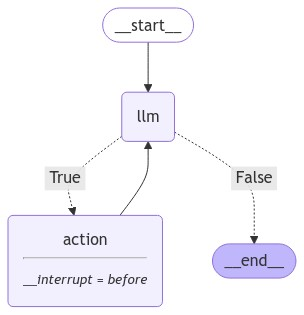

In [16]:
from IPython.display import Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

**- We could for instance try adding interrumpting (human-approval) to other nodes, like the `llm` one**

##### BONUS NOTE: Modifying the state of the agent

In [17]:
# next(abot.graph.get_state_history(thread))

In [91]:
memory = stack.enter_context(SqliteSaver.from_conn_string(":memory:"))
abot = Agent(model, [tool], system=prompt, checkpointer=memory)


messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
        
        
        

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'ty

**We runned until the action interrumpt, and then, we modify the state**

In [92]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpV

In [93]:
current_values = abot.graph.get_state(thread)

In [94]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 152, 'output_tokens': 21, 'total_tokens': 173, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [95]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB',
  'type': 'tool_call'}]

We'll be overriding the tool call it did in the lastest state, to be, also a `tavily search api call`, **but instead, to be a different query**

In [96]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
#we get the identifyer of this state so the graph know which one we're modyfing

current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Cordoba, Andalucia, Spain'},
  'id': _id}
]

The changues will actually make effect when we run `update_state()` with the thread converstation identifyer, and the new list representing the last state

In [97]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Cordoba, Andalucia, Spain'}, 'id': 'call_Glcpm1hp

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa3fcd-d7fd-65a1-8002-449693e1e6e9'}}

In [98]:
for i in abot.graph.get_state(thread).values["messages"]:
    
    print(i)

content='Whats the weather in LA?' additional_kwargs={} response_metadata={} id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'
content='' additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Cordoba, Andalucia, Spain'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'type': 'tool_call'}] usage

In [99]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Cordoba, Andalucia, Spain'},

In [100]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Cordoba, Andalucia, Spain'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Cordoba\', \'region\': \'Andalucia\', \'country\': \'Spain\', \'lat\': 37.8833, \'lon\': -4.7667, \'tz_id\': \'Europe/Madrid\', \'localtime_epoch\': 1731748939, \'localtime\': \'2024-11-16 10:22\'}, \'current\': {\'last_updated_epoch\': 1731748500, \'last_updated\': \'2024-11-16 10:15\', \'temp_c\': 14.2, \'temp_f\': 57.6, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 6.5, \'wind_kph\': 10.4, \'wind_degree\': 64, \'wind_dir\': \'ENE\', \'pressure_mb\': 1018.0, \'pressure_in\': 30.06, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 94, \'cloud\': 25, \'feelslike_c\':

We have know seen how we can modify states, whereas we can notice that those modified states are actually creating a **new state** to be runned once we get the graph running from where it stopped.

This allow us to access to all the previous states, (included the overriden ones), this is called `time travel`

In [101]:
states = []

for state in abot.graph.get_state_history(thread):
    
    print(state)
    
    print("---")
    
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Cordoba, Andalucia, Spain'},

**Update note:** To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.

In [106]:
to_replay = states[-3] # to_replay = states[-1]

In [107]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpV

We see that the last stored `state` was the earliest/original one that the llm did to call tavily search with the `weather in LA`

In case we want to resume from this checkpoint where it was `looking for LA`, we easily can

- We just run `stream()` again passing 
```python
abot.graph.stream(None, to_replay.config)

In [ ]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1731754081, \'localtime\': \'2024-11-16 02:48\'}, \'current\': {\'last_updated_epoch\': 1731753900, \'last_updated\': \'2024-11-16 02:45\', \'temp_c\': 10.6, \'temp_f\': 51.1, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 8.5, \'wind_kph\': 13.7, \'wind_degree\': 346, \'wind_dir\': \'NNW\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.9, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 61, \'cloud\': 0, \'feelslike_c

##### BONUS NOTE: Go back in time and edit

In [110]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpV

This is different from before, because instead of editing the last state in the graph, we went back in time with `state_history()` and then we edited

In [ ]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [112]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

#we then update this specific state

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_Glcpm1hpVsMuedEKBG

In [113]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1731756102, \'localtime\': \'2024-11-16 03:21\'}, \'current\': {\'last_updated_epoch\': 1731755700, \'last_updated\': \'2024-11-16 03:15\', \'temp_c\': 10.2, \'temp_f\': 50.4, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 7.4, \'wind_kph\': 11.9, \'wind_degree\': 344, \'wind_dir\': \'NNW\', \'pressure_mb\': 1013.0, \'pressure_in\': 29.9, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 61, \'cloud\': 0, \

**Now it called `tavily api but it used accuweather as source of information` instead, due to the modification we did just before**

##### **BONUS NOTE:** Add message to a state at any given point in time

Imagine that instead of calling that tool we edited before (`{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB'`)

We decide to mock out our own response and append that `message` to the corresponding state 

In [117]:
# to_replay

In [116]:
to_replay.values

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_Glcpm1hpVsMuedEK

In [ ]:
#we access to the ID
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [118]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

#we pretend to have already "called the function" so we put this as response from the API

In [ ]:
#since we're not just modifying now, we need to let the graph now that the action tavily call was already done

#so the message we're adding is the tavily_response

branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action") #with this new param


In this way, the graph won't go to the `action` node, but instead the llm will already use this `state_update` content we wrote as the "mock response from the api"

In [120]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='82ce5597-89d0-42ac-80f6-e45d2b0c5353'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'function': {'arguments': '{"query":"weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 152, 'total_tokens': 173, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4306fe76-b5bc-443c-a469-78d5fea6b099-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Glcpm1hpVsMuedEKBG6vLlUB', 'ty

So we see how, it now just runs the llm with this "mock response" instead of calling actions